### Loading the JSON file

In [1]:
import json

def load_plans(file_path):
    """
    Load parsed query plans from a JSON file.
    
    Args:
        file_path (str): Path to the JSON file.
        
    Returns:
        list: A list of parsed query plans.
    """
    with open(file_path, 'r') as f:
        plans = json.load(f)
    return plans

# Load training and validation plans
train_plans = load_plans('../tpch_data_20000/train_plans.json')
val_plans = load_plans('../tpch_data_20000/val_plans.json')




In [2]:
print(f"Number of training plans: {len(train_plans['parsed_plans'])}")
print(f"Number of validation plans: {len(val_plans['parsed_plans'])}")

Number of training plans: 19531
Number of validation plans: 4883


## Feature Extraction
### Defining the Feature Extraction Function

In [3]:
from collections import defaultdict
import numpy as np

def extract_features(parsed_plan):
    """
    Extract features from a parsed PostgreSQL query plan.

    Args:
        parsed_plan (dict): The parsed query plan.

    Returns:
        dict: A dictionary of aggregated features.
    """
    features = defaultdict(float)
    op_counts = defaultdict(int)
    numerical_features = defaultdict(list)
    max_depth = 0

    def traverse(node, depth=1):
        nonlocal max_depth
        max_depth = max(max_depth, depth)

        params = node.get('plan_parameters', {})
        op_name = params.get('op_name', 'Unknown')
        op_counts[op_name] += 1

        # Collect numerical features
        numerical_features['est_startup_cost'].append(params.get('est_startup_cost', 0.0))
        numerical_features['est_cost'].append(params.get('est_cost', 0.0))
        numerical_features['est_card'].append(params.get('est_card', 0.0))
        numerical_features['est_width'].append(params.get('est_width', 0.0))
        numerical_features['workers_planned'].append(params.get('workers_planned', 0.0))
        numerical_features['est_children_card'].append(params.get('est_children_card', 0.0))

        # Recursively traverse children
        for child in node.get('children', []):
            traverse(child, depth + 1)

    traverse(parsed_plan)

    # Aggregate operation counts
    for op, count in op_counts.items():
        features[f'op_count_{op}'] = count

    # Aggregate numerical features
    for feature, values in numerical_features.items():
        features[f'{feature}_sum'] = sum(values)
        features[f'{feature}_mean'] = np.mean(values) if values else 0.0
        features[f'{feature}_max'] = max(values) if values else 0.0
        features[f'{feature}_min'] = min(values) if values else 0.0

    # Add structural features
    features['tree_depth'] = max_depth
    features['num_nodes'] = len(numerical_features['est_cost'])

    return features


### Applying Feature Extraction to All Plans

In [4]:
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

def prepare_dataset(plans):
    """
    Prepare a dataset by extracting features and collecting labels.

    Args:
        plans (list): A list of parsed query plans.

    Returns:
        pd.DataFrame: DataFrame containing features.
        pd.Series: Series containing labels (peak memory).
    """
    feature_dicts = []
    labels = []

    for plan in tqdm(plans['parsed_plans']):
        features = extract_features(plan)
        feature_dicts.append(features)
        labels.append(plan.get('peakmem', 0.0))  # Assuming 'peakmem' is the target

    # Convert to DataFrame
    df_features = pd.DataFrame(feature_dicts)
    df_labels = pd.Series(labels, name='peakmem')

    # Handle missing values if any
    df_features.fillna(0, inplace=True)

    # Encode categorical features (if any)
    # Assuming 'op_count_*' are categorical; adjust based on actual data
    op_count_features = [col for col in df_features.columns if col.startswith('op_count_')]
    # If they are counts, you might treat them as numerical
    # Otherwise, use label encoding or one-hot encoding as needed

    # Feature scaling (optional)
    scaler = StandardScaler()
    numerical_cols = [col for col in df_features.columns if any(sub in col for sub in ['est_startup_cost', 'est_cost', 'est_card', 'est_width', 'workers_planned', 'est_children_card'])]
    df_features[numerical_cols] = scaler.fit_transform(df_features[numerical_cols])

    return df_features, df_labels

# Prepare training and validation datasets
X_train, y_train = prepare_dataset(train_plans)
X_val, y_val = prepare_dataset(val_plans)
X_val = X_val[X_train.columns]

print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)


100%|██████████| 4883/4883 [00:01<00:00, 4666.99it/s]


Training features shape: (19531, 49)
Validation features shape: (4883, 49)


In [19]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1, 
    colsample_bytree=0.8,
    subsample=1.0

)

# Train the model
xgb_reg.fit(X_train, y_train)

xgb_reg.save_model('xgb_model.json')


In [20]:
# Predict on test set
y_pred = xgb_reg.predict(X_val)


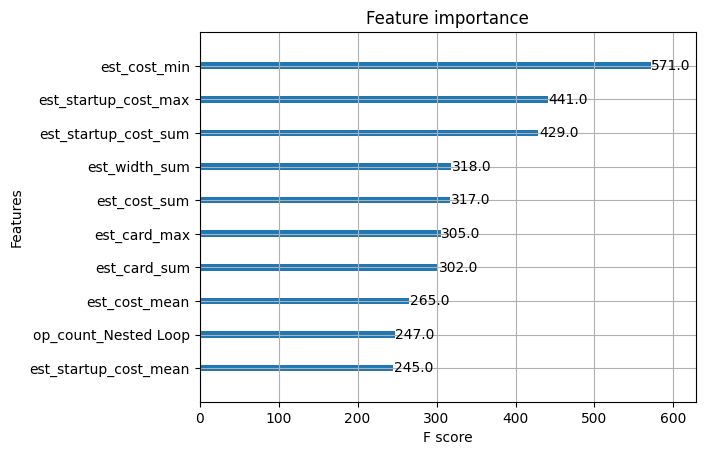

In [20]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importances
xgb.plot_importance(xgb_reg, max_num_features=10)
plt.show()


In [21]:
import numpy as np
import pandas as pd
import metrics
import importlib
importlib.reload(metrics)
metrics_dict = metrics.compute_metrics(y_val, y_pred)
for metric, value in metrics_dict.items():
    print(f"{metric}: {value:.4f}")

qerror_min: 1.0001
qerror_50 (Median): 1.5527
qerror_90: 3.3221
qerror_95: 3.8495
qerror_99: 5.3618
qerror_max: 9.2883
mean_qerror: 1.9075
mae: 29857.5746
mre: 0.8314
mse: 1368683570.4896
r2: 0.6025


In [11]:
def load_plans(file_path):
    """
    Load parsed query plans from a JSON file.
    
    Args:
        file_path (str): Path to the JSON file.
        
    Returns:
        list: A list of parsed query plans.
    """
    with open(file_path, 'r') as f:
        plans = json.load(f)
    return plans

# Load training and validation plans
train_plans = load_plans('../tpcds_data/train_plans.json')
val_plans = load_plans('../tpcds_data/val_plans.json')

X_test, y_test = prepare_dataset(train_plans)
X_test = X_test[X_train.columns]




100%|██████████| 53607/53607 [00:11<00:00, 4513.38it/s]


ValueError: feature_names mismatch: ['op_count_Aggregate', 'op_count_Seq Scan', 'est_startup_cost_sum', 'est_startup_cost_mean', 'est_startup_cost_max', 'est_startup_cost_min', 'est_cost_sum', 'est_cost_mean', 'est_cost_max', 'est_cost_min', 'est_card_sum', 'est_card_mean', 'est_card_max', 'est_card_min', 'est_width_sum', 'est_width_mean', 'est_width_max', 'est_width_min', 'workers_planned_sum', 'workers_planned_mean', 'workers_planned_max', 'workers_planned_min', 'est_children_card_sum', 'est_children_card_mean', 'est_children_card_max', 'est_children_card_min', 'tree_depth', 'num_nodes', 'op_count_Finalize Aggregate', 'op_count_Gather', 'op_count_Partial Aggregate', 'op_count_Hash Join', 'op_count_Parallel Seq Scan', 'op_count_Hash', 'op_count_Nested Loop', 'op_count_Bitmap Heap Scan', 'op_count_Bitmap Index Scan', 'op_count_Index Scan', 'op_count_Index Only Scan', 'op_count_Parallel Bitmap Heap Scan', 'op_count_Parallel Hash Join', 'op_count_Parallel Hash', 'op_count_Parallel Index Only Scan', 'op_count_Parallel Index Scan', 'op_count_Merge Join', 'op_count_Sort', 'op_count_BitmapAnd', 'op_count_Materialize', 'op_count_Memoize'] ['op_count_Aggregate', 'op_count_Merge Join', 'op_count_Nested Loop', 'op_count_Index Scan', 'op_count_Materialize', 'op_count_Gather', 'op_count_Parallel Seq Scan', 'op_count_Sort', 'op_count_Seq Scan', 'est_startup_cost_sum', 'est_startup_cost_mean', 'est_startup_cost_max', 'est_startup_cost_min', 'est_cost_sum', 'est_cost_mean', 'est_cost_max', 'est_cost_min', 'est_card_sum', 'est_card_mean', 'est_card_max', 'est_card_min', 'est_width_sum', 'est_width_mean', 'est_width_max', 'est_width_min', 'workers_planned_sum', 'workers_planned_mean', 'workers_planned_max', 'workers_planned_min', 'est_children_card_sum', 'est_children_card_mean', 'est_children_card_max', 'est_children_card_min', 'tree_depth', 'num_nodes', 'op_count_Finalize Aggregate', 'op_count_Partial Aggregate', 'op_count_Parallel Hash Join', 'op_count_Hash Join', 'op_count_Hash', 'op_count_Parallel Hash', 'op_count_Memoize', 'op_count_Parallel Bitmap Heap Scan', 'op_count_Bitmap Index Scan', 'op_count_Parallel Index Only Scan', 'op_count_Index Only Scan', 'op_count_Bitmap Heap Scan', 'op_count_BitmapAnd', 'op_count_Parallel Index Scan', 'op_count_Gather Merge']
training data did not have the following fields: op_count_Gather Merge

In [14]:
missing_cols = set(X_train.columns) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(X_train.columns)
for col in missing_cols:
    X_test[col] = 0
# X_test.drop(extra_cols, inplace=True)
X_test = X_test[X_train.columns]

In [16]:
import metrics
y_test_pred = xgb_reg.predict(X_test)
# Evaluate the model on the validation set
metrics_dict = metrics.compute_metrics(y_test, y_test_pred)
for metric, value in metrics_dict.items():
    print(f"{metric}: {value:.4f}")

qerror_min: 1.0000
qerror_50 (Median): 2.7522
qerror_90: 7.3695
qerror_95: 8.4042
qerror_99: 10.0122
qerror_max: 22.8185
mean_qerror: 3.5936
mae: 61060.4266
mre: 2.5702
mse: 4962975070.3537
r2: -2.8182


In [22]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score (Negative MSE): {grid_search.best_score_}")

# Use the best estimator for predictions
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_val)

# Compute metrics for the best model
metrics_best = metrics.compute_metrics(y_val, y_pred_best)

print("\nValidation Metrics for Best Model:")
for metric, value in metrics_best.items():
    print(f"{metric}: {value:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/wuy/software/anaconda3/envs/zsce/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/wuy/software/anaconda3/envs/zsce/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux201

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estima

In [18]:
# Evaluate
mse = mean_squared_error(y_val, y_pred_best)
r2 = r2_score(y_val, y_pred_best)

print(f"Test MSE: {mse:.2f}")
print(f"Test R² Score: {r2:.2f}")

NameError: name 'y_pred_best' is not defined

In [23]:
best_xgb.save_model('xgb_model_small_tpch_best_model.json')